In [1]:
import pandas as pd
data = pd.read_csv('C:/Users/wltmd/Downloads/학교/캡스톤/세번째 조별과제/AS_2018.csv', header = 0, encoding = 'ISO-8859-1')
data = data.values
data.shape

(8760, 6)

In [2]:
# 기온,일사,습도,전운량을 특징 데이터로 이용

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 특징과 타겟으로 분리
feature = data[:,1:5] # 특징
target = data[:,5] # 타겟

# MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(feature)
feature_scaled = scaler.transform(feature)

# 훈련/시험 셋으로 분리
X_train = feature_scaled[0:7296,0:4]
y_train = target[0:7296]
X_test = feature_scaled[7296:,0:4]
y_test = target[7296:]

In [2]:
# 전 시간 태양광 발전전력 특징 데이터에 추가

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 태양광 발전전력 특징 데이터에 추가하기
a = data[:,1:6]
b = np.delete(a, 0, axis = 0) # 첫번째 행 삭제
c = np.vstack((b, np.zeros([1,5]))) # 마지막 행 추가
d = c[:,4].reshape(8760,1)
feature = np.hstack((data[:,1:5], d))

# 여기서부터는 그대로 코딩
target = data[:,5] # 타겟

# MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(feature)
feature_scaled = scaler.transform(feature)

# 훈련/시험 셋으로 분리
X_train = feature_scaled[0:7296,0:5]
y_train = target[0:7296]
X_test = feature_scaled[7296:,0:5]
y_test = target[7296:]

In [29]:
# 기온/일사를 특징 데이터로 이용

# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # 특징과 타겟으로 분리
# feature = data[:,1:3] # 특징
# target = data[:,5] # 타겟

# # MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(feature)
# feature_scaled = scaler.transform(feature)

# # 훈련/시험 셋으로 분리
# X_train = feature_scaled[0:7296,0:2]
# y_train = target[0:7296]
# X_test = feature_scaled[7296:,0:2]
# y_test = target[7296:]

In [16]:
param_grid = {'C' : [1000], 'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'epsilon' : [10]}
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
grid_search = GridSearchCV(SVR(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("최적 매개변수:", grid_search.best_params_)
print("최고 교차 검증 점수:", grid_search.best_score_)

최적 매개변수: {'C': 1000, 'epsilon': 10, 'gamma': 1}
최고 교차 검증 점수: 0.9635585627335927


In [ ]:
# 히트맵 그리기

# results = pd.DataFrame(grid_search.cv_results_)
# scores = np.array(results.mean_test_score).reshape(6,6)
# mglearn.tools.heatmap(scores, xlabel='gamma',xticklabels=param_grid['gamma'],ylabel='C',yticklabels=param_grid['C'],cmap="viridis")

In [3]:
# 파이프라인 구축

from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 태양광 발전전력 특징 데이터에 추가하기
a = data[:,1:6]
b = np.delete(a, 0, axis = 0) # 첫번째 행 삭제
c = np.vstack((b, np.zeros([1,5]))) # 마지막 행 추가
d = c[:,4].reshape(8760,1)
feature = np.hstack((data[:,1:5], d))
# 여기서부터는 그대로 코딩
target = data[:,5] # 타겟

# 훈련/시험 셋으로 분리
X_train = feature[0:7296,0:5]
y_train = target[0:7296]
X_test = feature[7296:,0:5]
y_test = target[7296:]

# 파이프라인
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVR())])
pipe.fit(X_train, y_train)
param_grid = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'svm__epsilon' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.96
테스트 세트 점수: 0.95
최적의 매개변수:  {'svm__C': 1000, 'svm__epsilon': 10, 'svm__gamma': 1}


In [14]:
from sklearn.svm import SVR
svm = SVR(kernel = 'rbf', C = 1000, gamma = 1, epsilon = 10)
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
# svm.support_vectors_.shape
y_pred.shape

(1464,)

In [17]:
# 오차 구하기 MAPE(mean absolute percentage error)

# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     a = np.zeros([len(y_true),1])
#     for i in range(len(y_true)):
#         try:
#             a[i] = np.abs((y_true[i] - y_pred[i]) / y_true[i])
#         except OverflowError:
#             a[i] = 0
#     return np.sum(a) * 100 / len(y_true)

# mean_absolute_percentage_error(y_test, y_pred)

error = np.zeros([len(y_pred)])
MAPE = 0
num_error = len(y_pred)
for i in range(len(y_pred)):
    if y_test[i] == 0:
        error[i] = 0
    else:
        error[i] = abs(y_test[i] - y_pred[i]) / y_test[i]

MAPE = np.sum(error)/num_error*100
MAPE

38.890193613563305

In [15]:
# 오차 구하기

# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     try:
#         result = (y_true - y_pred) / y_true * 100
#     except ZeroDivisionError:
        
#     return result

# #     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# mean_absolute_percentage_error(y_test, y_pred)

ZeroDivisionError: float division by zero

In [32]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_test, y_pred)**0.5

RMSE

107.63166178611031

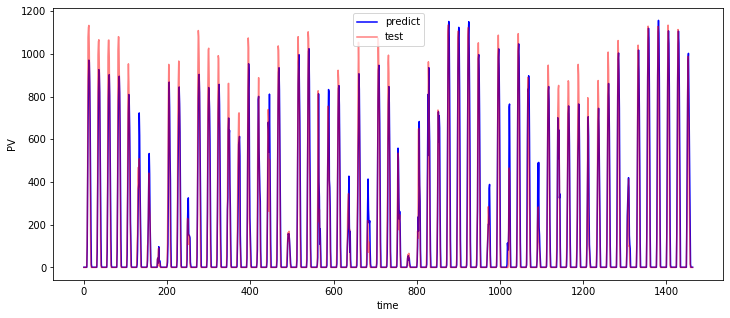

In [33]:
import matplotlib.pyplot as plt

x = np.arange(1464)
plt.figure(figsize=(12,5))
plt.plot(x, y_pred, color = 'blue', label = 'predict')
plt.plot(x, y_test, color = 'red', alpha = 0.5, label = 'test')
plt.xlabel("time")
plt.ylabel("PV")
plt.legend()